In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import sys
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Data Preparation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [3]:
dataset_path = './data/wikiart_sample/'
dataset = ImageFolder(root=dataset_path, transform=transform)

In [4]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [5]:
class AutoencoderClassifier(nn.Module):
    def __init__(self):
        super(AutoencoderClassifier, self).__init__()

        # Encoder layers
        self.enc1 = nn.Conv2d(3, 32, 3, padding=1)
        self.enc2 = nn.Conv2d(32, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Decoder layers
        self.dec1 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        self.dec2 = nn.ConvTranspose2d(32, 3, 2, stride=2)

        # Classifier layers
        self.fc1 = nn.Linear(16*32*32, 64)
        self.fc2 = nn.Linear(64, 27)

    def forward(self, x):
        # Encoder
        x = F.relu(self.enc1(x))
        x = self.pool(x)
        x = F.relu(self.enc2(x))
        encoded = self.pool(x)

        # Decoder (though we won't be using the decoder output for classification, it's still part of the network)
        x_decoded = F.relu(self.dec1(encoded))
        x_decoded = torch.sigmoid(self.dec2(x_decoded))

        # Classifier
        x_classified = encoded.view(-1, 16*32*32)
        x_classified = F.relu(self.fc1(x_classified))
        x_classified = self.fc2(x_classified)

        return x_classified, encoded  # Return both the classification output and the latent representation

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [7]:
# Model Initialization
model = AutoencoderClassifier()
model.to(device)  # Move model to device

AutoencoderClassifier(
  (enc1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec1): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (dec2): ConvTranspose2d(32, 3, kernel_size=(2, 2), stride=(2, 2))
  (fc1): Linear(in_features=16384, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=27, bias=True)
)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Training Loop
for epoch in range(6):  # Loop over the dataset multiple times
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        classified_output, latent_activations = model(inputs)  # Unpack both outputs here
        loss = criterion(classified_output, labels)  # Change this line to use the classification output
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print(f"[Epoch {epoch+1}, Mini-batch {i+1}] loss: {loss.item()}")
        sys.stdout.write(f"\r[Epoch {epoch+1}, Mini-batch {i+1}] loss: {loss.item()}")

    # Validation
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            classified_output, _ = model(inputs)  # Here, we ignore the latent activations during validation
            _, predicted = torch.max(classified_output.data, 1)  # Change this line as well
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # print(f'Validation accuracy after epoch {epoch+1}: {100 * correct / total}%')
    sys.stdout.write(f'\rValidation accuracy after epoch {epoch+1}: {100 * correct / total}%')
    sys.stdout.flush()

Validation accuracy after epoch 6: 18.21821821821822%%

In [10]:
torch.save(model, "wiki_encoder_model.pth")

In [11]:
##### Results Visualization

In [12]:
import collections
from collections import Counter

In [13]:
# Calculate the most frequent label in the training set
label_counts = Counter([label for _, label in train_dataset])
most_common_label, frequency = label_counts.most_common(1)[0]

# Calculate the expected accuracy if no model (always predicting the most frequent label)
baseline_accuracy = (frequency / len(train_dataset)) * 100
print(f"Expected accuracy if no model: {baseline_accuracy:.2f}%")

Expected accuracy if no model: 4.48%


In [14]:
actual_accuracy = 100 * correct / total
print(f'Validation accuracy after training: {actual_accuracy:.2f}%')

Validation accuracy after training: 18.22%


In [15]:
label_to_style = {
    0: 'Abstract',
    1: 'Baroque',
    2: 'Cubism',
    3: 'Expressionism',
    4: 'Fauvism',
    5: 'Impressionism',
    6: 'Pop Art',
    7: 'Realism',
    8: 'Renaissance',
    9: 'Romanticism',
    10: 'Surrealism',
    11: 'Symbolism',
    12: 'Art Nouveau',
    13: 'Art Deco',
    14: 'Gothic',
    15: 'Neoclassicism',
    16: 'Post-Impressionism',
    17: 'Minimalism',
    18: 'Rococo',
    19: 'Byzantine',
    20: 'Contemporary',
    21: 'Photorealism',
    22: 'Pointillism',
    23: 'Futurism',
    24: 'Suprematism',
    25: 'Constructivism',
    26: 'Naive Art'
}

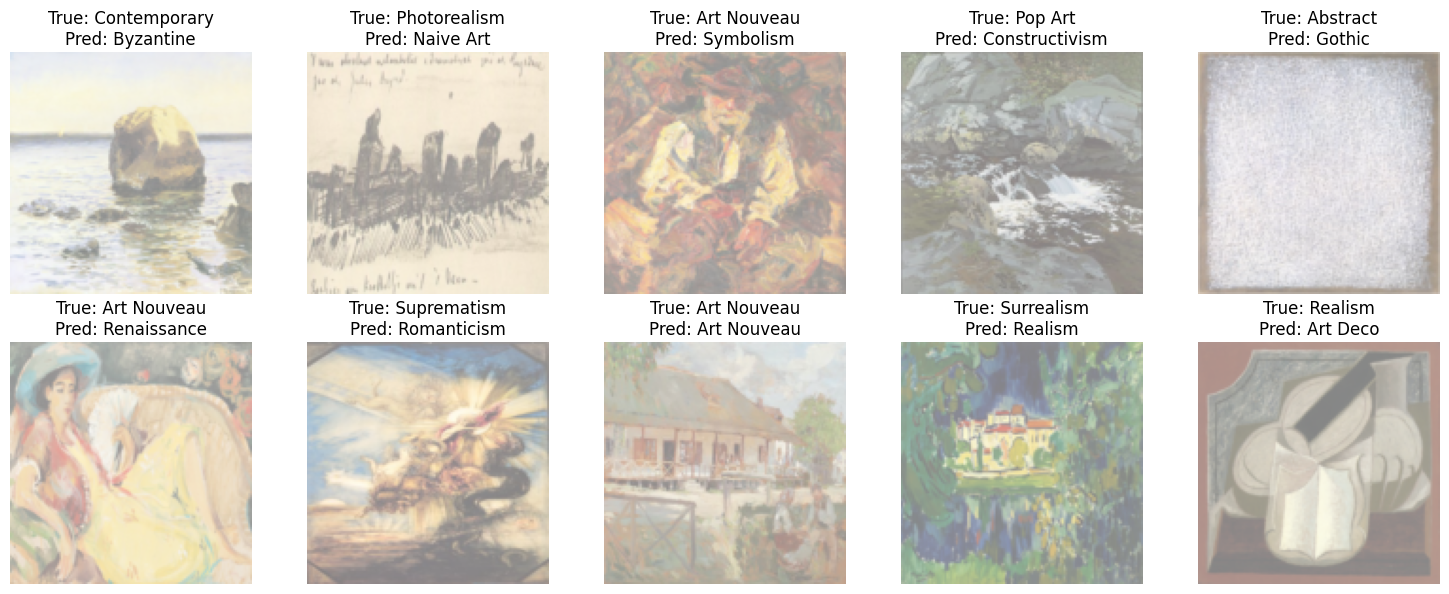

In [16]:
def imshow(img):
    img = img.cpu() / 2 + 0.5  # unnormalize and move to CPU
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Move the iterator and model to the same device (assuming model is on GPU)
dataiter = iter(val_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Get the model output
outputs, _ = model(images[:10])
_, predicted = torch.max(outputs.data, 1)

# Move images and labels back to CPU for visualization
images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()

# Show images with true and predicted labels
fig, axs = plt.subplots(2, 5, figsize=(15, 6))  # Adjusted for a 2x5 grid

for i in range(10):  # Loop 10 times for 10 images
    row = i // 5
    col = i % 5
    img = images[i] / 2 + 0.5  # unnormalize
    img = img.numpy()
    axs[row, col].imshow(np.transpose(img, (1, 2, 0)))

    true_label = label_to_style[int(labels[i].item())]  # Make sure label_to_style is defined
    predicted_label = label_to_style[int(predicted[i].item())]

    axs[row, col].set_title(f"True: {true_label}\nPred: {predicted_label}")
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

In [17]:
##### Confusion Metrics

In [18]:
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in val_loader:
        # Move inputs and labels to the same device as the model (assuming it's on GPU)
        inputs, labels = inputs.to(device), labels.to(device)

        outputs, _ = model(inputs[:10])
        predicted_labels = labels[:10]
        _, predicted = torch.max(outputs.data, 1)

        # Move predicted_labels and predicted back to CPU for further processing
        predicted_labels = predicted_labels.cpu()
        predicted = predicted.cpu()

        all_labels.extend(predicted_labels)
        all_preds.extend(predicted)

# Convert to Python integers
all_labels = [label.item() for label in all_labels]
all_preds = [pred.item() for pred in all_preds]

# Calculate the confusion matrix
conf_mat = confusion_matrix(all_labels, all_preds)

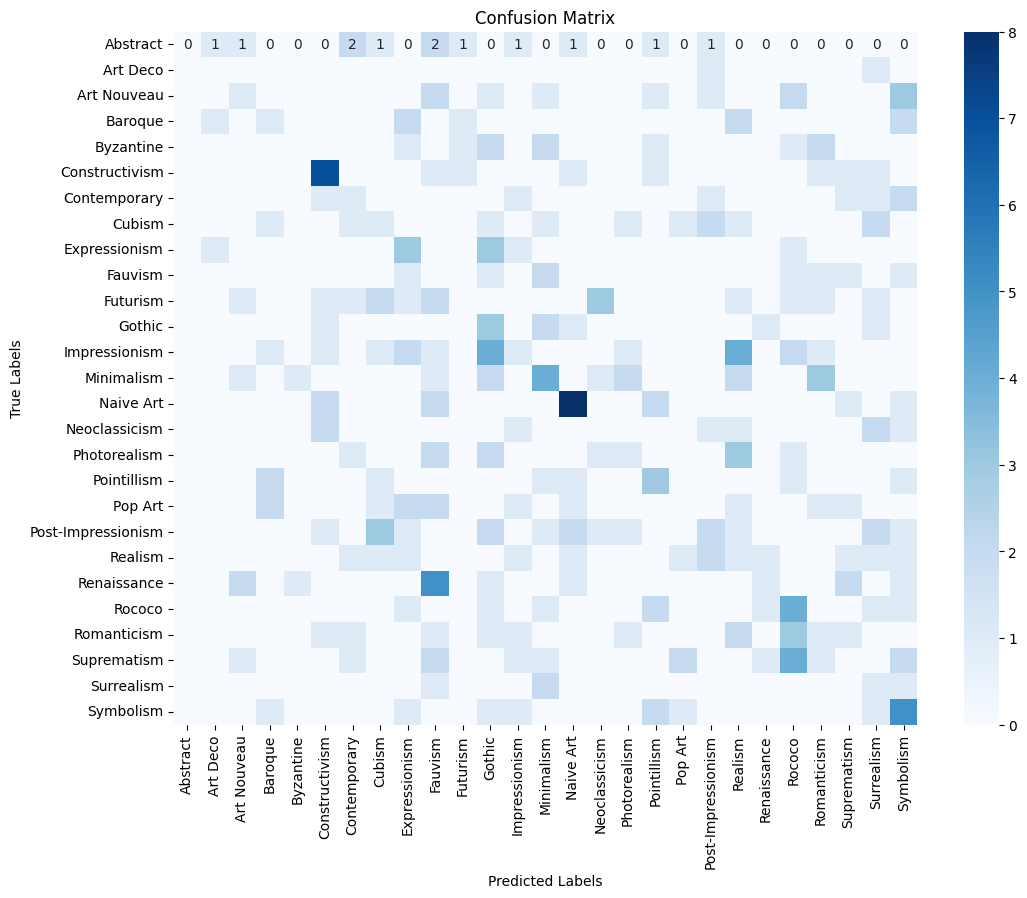

In [19]:
unique_styles = sorted(list(label_to_style.values()))

plt.figure(figsize=(12, 9))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_styles,
            yticklabels=unique_styles)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Number of times each node is active across classes: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


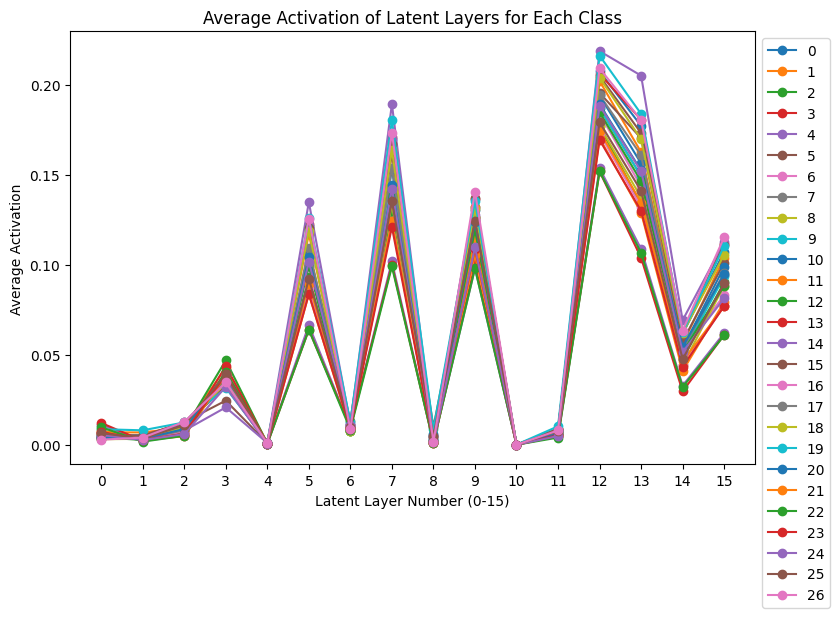

In [30]:
all_latent_activations = []
all_labels = []


net = AutoencoderClassifier()

# Forward pass through the network and collect latent activations
with torch.no_grad():
    for inputs, labels in train_loader:
      _, latent_activations = net(inputs)  # forward pass
      all_latent_activations.append(latent_activations)
      all_labels.append(labels)

all_latent_activations = torch.cat(all_latent_activations, axis=0)
all_labels = torch.cat(all_labels, axis=0)

# Average over the spatial dimensions (32x32) for each of the 16 layers
averaged_activations = all_latent_activations.mean(axis=(2,3))  # shape should now be [batch_size, 16]

# Compute average activation for each class
num_classes = 27
avg_latent_activations = torch.zeros((16, num_classes))

for i in range(num_classes):
    class_indices = (all_labels == i).nonzero(as_tuple=True)[0]
    avg_latent_activations[:, i] = torch.mean(averaged_activations[class_indices], axis=0)

# Determine which nodes are "active" using a threshold
threshold = 0.5
active_nodes = (avg_latent_activations > threshold).sum(axis=1)

print(f"Number of times each node is active across classes: {active_nodes}")

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
lines = ax.plot(avg_latent_activations.numpy(), 'o-')

# Customize x-axis
plt.xticks(range(16))

# Customize y-axis and labels
plt.xlabel('Latent Layer Number (0-15)')
plt.ylabel('Average Activation')
plt.title("Average Activation of Latent Layers for Each Class")

# Move Legend outside plot area
plt.legend(lines, range(num_classes), loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout(rect=[0,0,0.85,1])

plt.show()

In [24]:
##### GRAD CAM

In [33]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.model.eval()
        self.feature = None
        self.gradient = None
        self.handlers = []

    def save_gradient(self, grad):
        self.gradient = grad

    def __call__(self, x, target_class=None):
        # Register hooks
        self.handlers.append(self.target_layer.register_forward_hook(self.save_feature))
        self.handlers.append(self.target_layer.register_backward_hook(self.save_gradient))

        # logits = self.model(x)
        logits, _ = self.model(x)
        if target_class is None:
            target_class = logits.argmax(dim=1).item()

        score = logits[:, target_class]
        self.model.zero_grad()
        score.backward(torch.ones_like(score))

        weights = F.adaptive_avg_pool2d(self.gradient, (1, 1))
        cam = (weights * self.feature).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam -= cam.min()
        cam /= cam.max()

        # Remove hooks
        for handler in self.handlers:
            handler.remove()

        return cam

    def save_feature(self, module, input, output):
        self.feature = output.detach()

    def save_gradient(self, module, grad_in, grad_out):
        self.gradient = grad_out[0].detach()

    def visualize(self, cam, input_image):
        input_image = input_image.squeeze().permute(1, 2, 0).cpu().numpy()
        cam = cam.squeeze().cpu().numpy()
        height, width, _ = input_image.shape
        cam_resized = F.interpolate(torch.tensor(cam).unsqueeze(0).unsqueeze(0), size=(height, width), mode='bilinear', align_corners=False)
        cam_resized = cam_resized.squeeze().cpu().numpy()
        cam_resized = (255 * (cam_resized - cam_resized.min()) / (cam_resized.max() - cam_resized.min())).astype("uint8")
        heatmap = plt.cm.jet(cam_resized)[:,:,:3]
        input_image = (255 * (input_image - input_image.min()) / (input_image.max() - input_image.min())).astype('uint8')
        overlay = ((0.6 * input_image) + (0.4 * heatmap * 255)).astype('uint8')

        # Plotting
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(input_image)
        axs[0].axis('off')
        axs[0].set_title('Original Image')
        axs[1].imshow(overlay)
        axs[1].axis('off')
        axs[1].set_title('Grad-CAM Visualization')
        plt.tight_layout()
        plt.show()

In [34]:
grad_cam = GradCAM(model, model.enc2)

In [41]:
input_image, target_class = dataset[3]
input_image = input_image.unsqueeze(0).to(device)

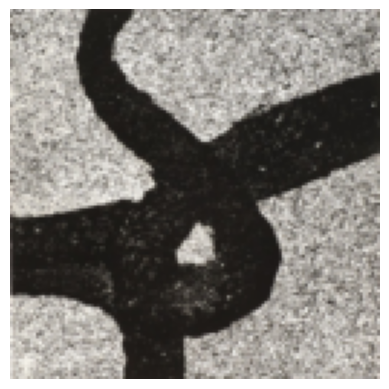

In [42]:
image = input_image[0].cpu().detach().permute(1, 2, 0).numpy()

# Clip values to [0, 1] to ensure valid display of image
image = image.clip(0, 1)

# Display the image
plt.imshow(image)
plt.axis('off')  # hide axes for better visualization
plt.show()

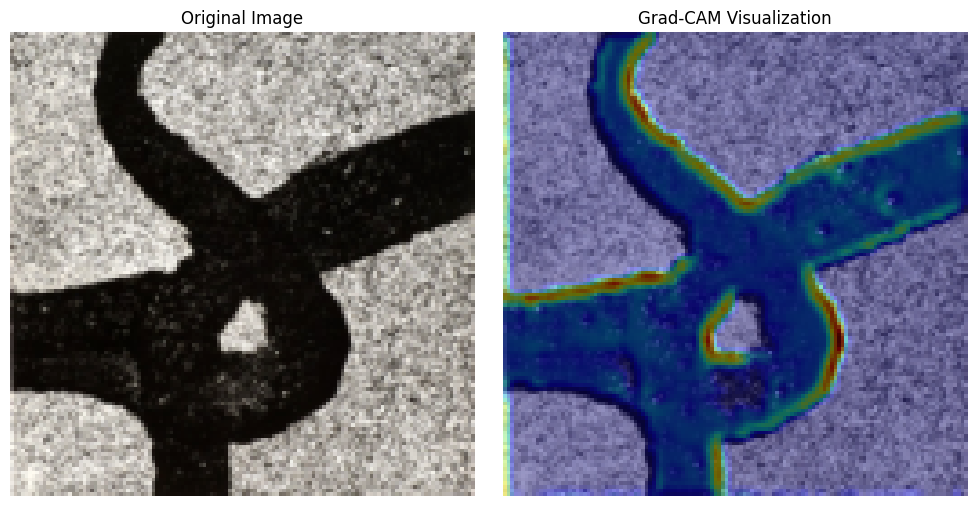

In [43]:
# Generate CAM
cam = grad_cam(input_image)
grad_cam.visualize(cam, input_image)